In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Define Parameters
num_classes = 5
IMG_SIZE = 224
BATCH_SIZE = 32
BS = 64
NUM_WORKERS = 4 # You might adjust this based on your system's capabilities
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
From (redirected): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7&confirm=t&uuid=a817972b-667a-485d-ad60-a61de7d1cd4c
To: /content/retina-dataset.zip
100% 622M/622M [00:06<00:00, 89.5MB/s]


In [ ]:
# unzip dataset file
!unzip -q retina-dataset.zip

replace kaggle_retina/submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Data Visualization

In [ ]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [ ]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/b8297a2291f5.png
label: 0


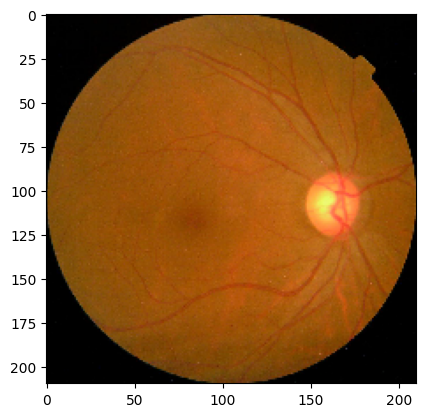

In [ ]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
path = f"kaggle_retina/train/{filename}.png"
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [ ]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

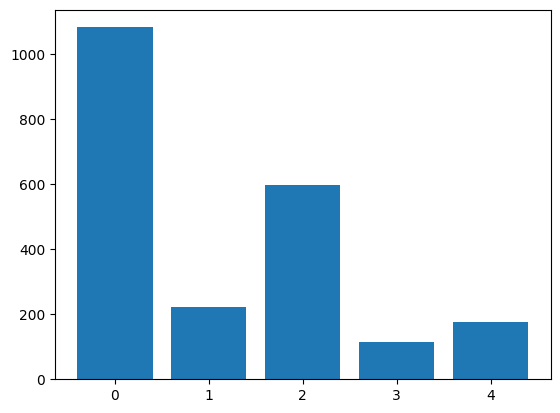

In [ ]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### [TODO] Dataset, DataLoader

In [ ]:
import torch
import torch.utils.data
import pandas as pd
from torchvision import transforms
from PIL import Image

class RetinaDataset_Torchvision(torch.utils.data.Dataset):
    def __init__(self, df, aug, img_size=224):
        self.df = df
        self.img_size = img_size
        self.aug = aug

        # torchvision
        if self.aug:
            # transforms.Compose
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5), # 50% 水平翻轉
                transforms.RandomVerticalFlip(p=0.5),   # 50% 垂直翻轉
                transforms.RandomAffine(
                    degrees=(-45, 45),    # 旋轉
                    scale=(0.8, 1.2),     # 縮放
                    shear=(-16, 16)       # 剪切
                ),

                # 2. 將 PIL Image 轉換為 PyTorch Tensor ([0, 1] 歸一化也在此步驟完成)
                transforms.ToTensor(),

                # 3. 調整圖像大小 (在 ToTensor 之後進行)
                transforms.Resize((self.img_size, self.img_size), antialias=True)
            ])
        else:
            # 如果不增強，只做 Resize 和 Tensor 轉換
            self.transform = transforms.Compose([
                transforms.Resize((self.img_size, self.img_size), antialias=True),
                transforms.ToTensor()
            ])


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png" #讀取圖像

        # ⚠️ 使用 PIL 讀取圖像，並確保是 RGB 格式
        img = Image.open(path).convert("RGB")

        # 應用 torchvision 轉換
        img_tensor = self.transform(img)

        label = row["diagnosis"]
        label_tensor = torch.tensor(label, dtype=torch.long)

        return img_tensor, label_tensor

In [ ]:
df = pd.read_csv("kaggle_retina/train.csv")
train_df, val_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=5566)

In [ ]:
train_ds = RetinaDataset_Torchvision(train_df, aug=True, img_size=IMG_SIZE)
val_ds = RetinaDataset_Torchvision(val_df, aug=False, img_size=IMG_SIZE)

899 tensor(0)


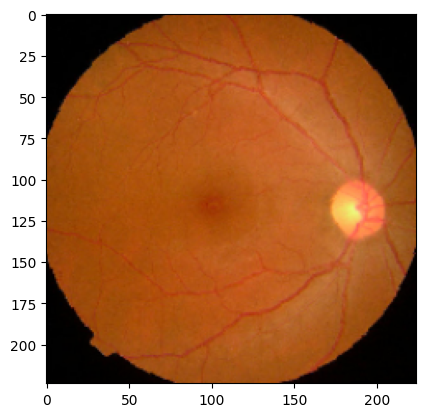

In [ ]:
idx = np.random.randint(0, len(train_ds))
img, label = train_ds[idx]
print(idx, label)
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

#### [TODO] Model

In [ ]:
class ConvBlock(nn.Sequential):
    def __init__(self, cin, cout):
        super().__init__(
            nn.Conv2d(cin, cout, 3, padding='same'),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.Conv2d(cout, cout, 3, padding='same'),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding='same'),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.Conv2d(cout, cout, 3, padding='same'),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self, x):
        return self.conv(x)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3, 32), # size / 2
            ConvBlock(32, 64), # size / 4
            ConvBlock(64, 128), # size / 8
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(28*28*128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
class CNN2(torch.nn.Module):
    def __init__(self, cnn):
        super().__init__()
        self.cnn = cnn
        self.new_layer = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.cnn.encoder(x)
        x = self.new_layer(x)
        x = self.cnn.flatten(x)
        x = self.cnn.classifier(x)
        return x

#### [TODO] Training

In [ ]:
import torch.nn as nn
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters()) # Adam

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

 10%|█         | 1/10 [00:30<04:38, 30.97s/it]

EPOCH: 0000     train_loss: 5.7147, train_acc: 0.408     val_loss: 1.5096, val_acc: 0.318 



 20%|██        | 2/10 [00:57<03:46, 28.30s/it]

EPOCH: 0001     train_loss: 1.4703, train_acc: 0.513     val_loss: 1.2394, val_acc: 0.614 



 30%|███       | 3/10 [01:24<03:15, 27.93s/it]

EPOCH: 0002     train_loss: 1.2582, train_acc: 0.554     val_loss: 1.1029, val_acc: 0.634 



 40%|████      | 4/10 [01:55<02:54, 29.14s/it]

EPOCH: 0003     train_loss: 1.1455, train_acc: 0.581     val_loss: 0.9406, val_acc: 0.661 



 50%|█████     | 5/10 [02:22<02:20, 28.15s/it]

EPOCH: 0004     train_loss: 1.0733, train_acc: 0.635     val_loss: 0.9864, val_acc: 0.659 



 60%|██████    | 6/10 [02:48<01:50, 27.56s/it]

EPOCH: 0005     train_loss: 1.0269, train_acc: 0.635     val_loss: 0.9723, val_acc: 0.657 



 70%|███████   | 7/10 [03:15<01:22, 27.42s/it]

EPOCH: 0006     train_loss: 1.0421, train_acc: 0.629     val_loss: 0.8980, val_acc: 0.670 



 80%|████████  | 8/10 [03:42<00:54, 27.29s/it]

EPOCH: 0007     train_loss: 1.0093, train_acc: 0.647     val_loss: 0.9388, val_acc: 0.652 



 90%|█████████ | 9/10 [04:09<00:27, 27.05s/it]

EPOCH: 0008     train_loss: 1.0249, train_acc: 0.639     val_loss: 0.9260, val_acc: 0.691 



100%|██████████| 10/10 [04:35<00:00, 27.59s/it]

EPOCH: 0009     train_loss: 0.9843, train_acc: 0.648     val_loss: 1.0018, val_acc: 0.657 


#### Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [ ]:
#model.load_state_dict(torch.load('best.pth'))
#_ = model.eval().to(device)

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_size=224):
        self.df = df
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, IMG_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, BS)

In [ ]:
# Inference
y_pred = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

In [ ]:
df['diagnosis'] = y_pred
df.to_csv('Retinopathy classificationV3.csv', index=None)